# Advanced Regression Techniques: Predicting House Prices In Ames, Iowa with XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Load the data

In [2]:
train = pd.read_csv('data/houseprices/train.csv')
test = pd.read_csv('data/houseprices/test.csv')
sample_submission = pd.read_csv('data/houseprices/sample_submission.csv')

In [7]:
len(train)

1460

In [3]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [4]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [37]:
sample_submission.head(2)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989


We shall add the sample sales data to the test set to have similar number of columns for test and train. This is just a convinience to allow us concatenate the two for aggregated preprocessing

## Preprocess data

### Outliers
There are some outliers as pointed out by Dean De Cock in the dataset description which can be visualized in a scatter of sales vs square living area

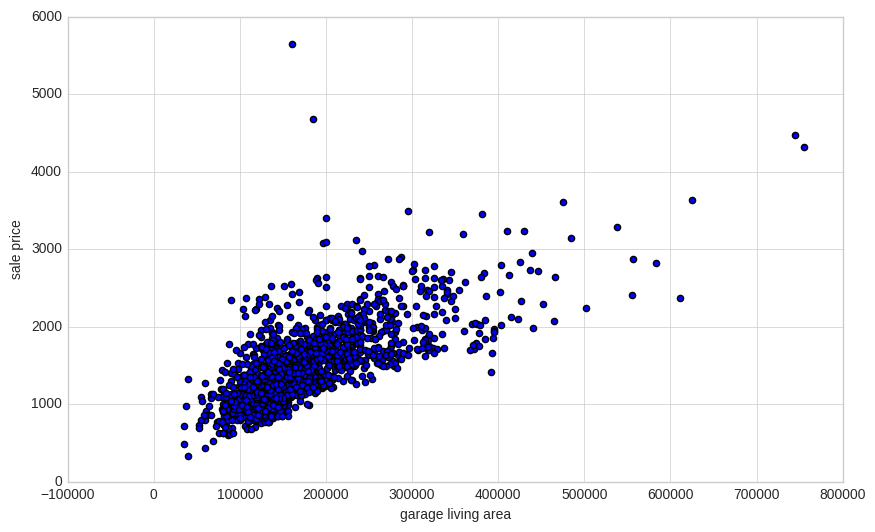

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(train.SalePrice, train.GrLivArea)
ax.set(xlabel='garage living area', ylabel='sale price')

plt.show()

In [39]:
train.Id[train.GrLivArea>4000]

523      524
691      692
1182    1183
1298    1299
Name: Id, dtype: int64

In [40]:
# remove train outliers
train = train[train.GrLivArea<4000]

In [41]:
# replace Alley NA with None
train.Alley.fillna('None', inplace=True)

# replace MasVnrArea na with 0
train.MasVnrArea.fillna(0, inplace=True)

# replace LotFrontage NA with mean
train.LotFrontage.fillna(train.LotFrontage.mean(), inplace=True)

# replace NAs from not having a basement, freplace, garage, pool, miscellaneous feature
# fence with None
na_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageType', \
           'BsmtFinType1', 'BsmtFinType2', 'GarageYrBlt', 'GarageFinish', \
           'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for col in na_columns:
    train[col].fillna('None', inplace=True)

# convert month and year columns to category
mm_yr_columns = ['YrSold', 'GarageYrBlt', 'MoSold', 'YearBuilt', 'YearRemodAdd']
# print('Dtype of ', mm_yr_columns, 'before: \n', houses[mm_yr_columns].dtypes)
for col in mm_yr_columns:
    train[col] = test[col].astype('category')
# print('Dtype of ', mm_yr_columns, 'after: \n', houses[mm_yr_columns].dtypes)

## create dummy variables

In [42]:
# encode dataframe
train_dummy = pd.get_dummies(train)

In [43]:
train_dummy.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,196.0,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,0.0,978,0,284,...,0,0,0,1,0,0,0,0,1,0


## split train data for cross validation

In [44]:
from sklearn.model_selection import train_test_split
X = train_dummy.drop(['Id', 'SalePrice'], axis=1)
y = train_dummy.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# TSNE

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE()

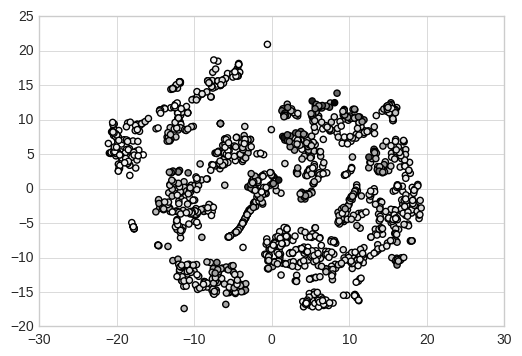

In [46]:
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)

In [53]:
len(train_dummy.Id)

1456

In [54]:
len(y)

1456

In [47]:
from bokeh.io import output_notebook, show

In [48]:
output_notebook()

Loading BokehJS ...

In [55]:
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource


source = ColumnDataSource(
        data=dict(
            x=X_tsne[:, 0],
            y=X_tsne[:, 1],
            Id=train_dummy.Id,
        )
    )

hover = HoverTool(
        tooltips=[
            ("Id", "@Id")
        ]
    )

p = figure(plot_width=800, plot_height=800, tools=[hover], title="TSNE train data")

p.circle('x', 'y', size=10, source=source)

show(p)

## define the accuracy function: log root mean square error

In [58]:
def mylog_rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(np.log10(y_true), np.log10(y_pred)))

## Grid search

In [1]:
from sklearn.model_selection import GridSearchCV, KFold
from xgboost.sklearn import XGBRegressor

In [3]:
XGBRegressor?

In [16]:
XGBRegressor

In [82]:
# 5 splits, shuffle
kfold = KFold(n_splits=5, random_state=0)
# grid parameters
param_grid = {'learning_rate': [0.1, 0.5, 1], 
              'max_depth': [2, 5, 7]} 
# grid search
grid_search = GridSearchCV(XGBRegressor(seed=0, n_estimators=200), 
                           param_grid, cv=kfold, scoring='neg_mean_squared_error')
%time grid_search.fit(X_train, y_train)

print("Test set log adj RMSE: {:.5f}".format(mylog_rmse(y_test, grid_search.predict(X_test))))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

CPU times: user 3min 19s, sys: 1.94 s, total: 3min 21s
Wall time: 2min 20s
Test set log adj RMSE: 0.04938
Best parameters: {'learning_rate': 0.1, 'max_depth': 2}
Best cross-validation score: -652056918.32


In [71]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.16, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [15]:
def plot_feature_importance(xgbr, X):
    fig, ax = plt.subplots(figsize=(6, 40))
    imp = xgbr.feature_importances_
    imp /= imp.max()
    names = X.columns
    x = range(len(names))
    ax.barh(x, imp, align='center')
    ax.set(title='Feature Importances', xlabel='importance', ylabel='feature', ylim=(0, 410), yticks=x) 
    ax.set_yticklabels(names, fontsize=7)
    plt.show();

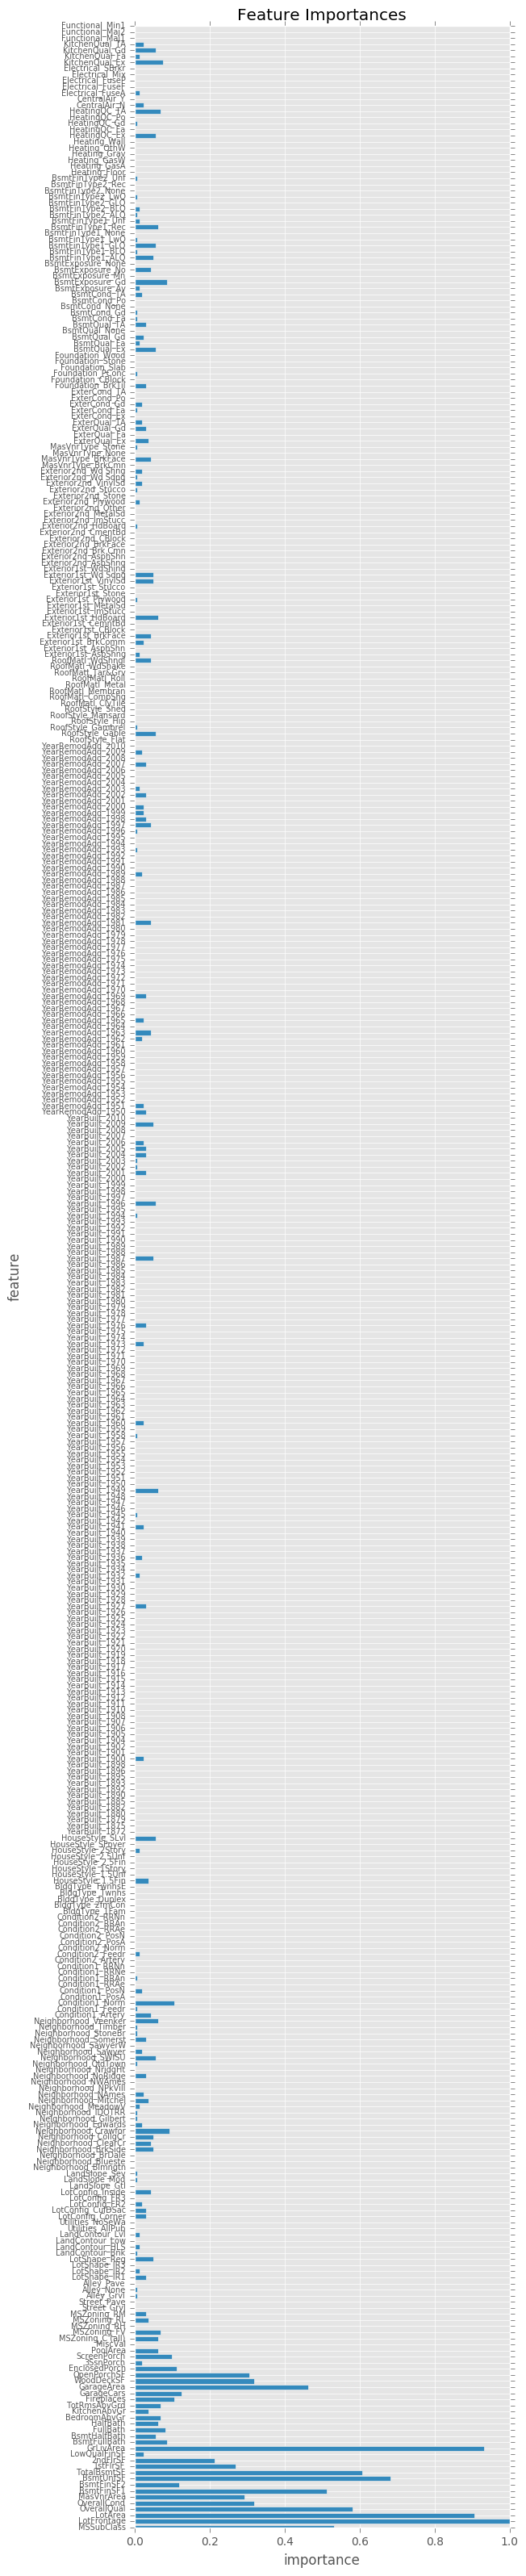

In [16]:
plot_feature_importance(grid_search.best_estimator_, X_train)

## Plots

### train, test error Vs number of estimators

In [51]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [29]:
np.array(results.mean_test_score).reshape(3, 3)

array([[ -1.06847147e+09,  -1.47921467e+09,  -1.50964414e+09],
       [ -6.57310371e+08,  -8.35776268e+08,  -8.78573246e+08],
       [ -5.69953168e+08,  -6.32845225e+08,  -7.05269081e+08]])

In [49]:
np.array(results.mean_test_score)

array([ -1.06847147e+09,  -1.47921467e+09,  -1.50964414e+09,
        -6.57310371e+08,  -8.35776268e+08,  -8.78573246e+08,
        -5.69953168e+08,  -6.32845225e+08,  -7.05269081e+08])

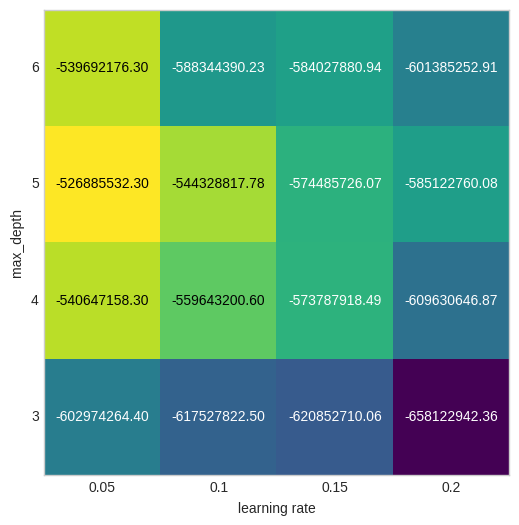

In [52]:
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(4, 4)
# plot the mean cross-validation scores
fig, ax = plt.subplots(figsize=(6,6))
heatmap(scores, xlabel='learning rate', xticklabels=param_grid['learning_rate'],
ylabel='max_depth', yticklabels=param_grid['max_depth'], cmap="viridis", ax=ax)

In [62]:
from sklearn.model_selection import validation_curve, cross_val_score

In [68]:
def plot_validation_curve(parameter_values, train_scores, validation_scores, ax, depth):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    ax.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    ax.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    ax.set_ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    ax.set(title='max depth={}'.format(depth), xlabel='learning rate', ylabel='rmse')

    plt.legend(loc="best")

In [89]:
np.linspace(0.05, 0.17, 13)

array([ 0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,
        0.14,  0.15,  0.16,  0.17])

/home/arnoldo/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/arnoldo/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


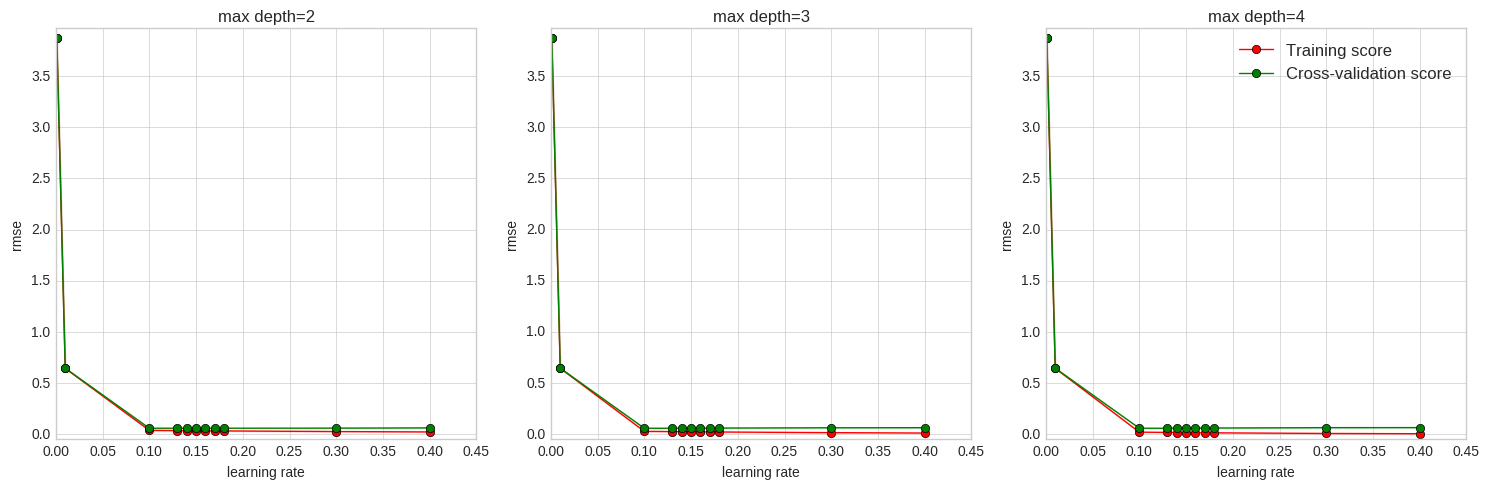

In [92]:
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.001, 0.01, 0.1, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.3, 0.4]
max_depth = [2, 3, 4]
reg_lambda = [0.001, 0.01, 0.1, 1]
gamma = [0, 1, 5, 10, 100]
subsample = [0.5, 0.7, 1]

fig, axes = plt.subplots(ncols=len(max_depth), figsize=(15, 5))

colors = ['red', 'blue', 'green', 'yellow', 'orange']

for depth, ax in zip(max_depth, axes):    
   
    train_scores, valid_scores = validation_curve(XGBRegressor(seed=0, n_estimators=200, max_depth=depth), \
                                                  X_train, np.log10(y_train), 'learning_rate', learning_rate, \
                                                  cv=5, scoring='neg_mean_squared_error')
    
    train_scores, valid_scores = np.sqrt(train_scores*-1), np.sqrt(valid_scores*-1)
    
    plot_validation_curve(learning_rate, train_scores, valid_scores, ax, depth)

fig.tight_layout()
plt.show();

## Preprocess Test data

In [31]:
def columns_with_na(df):
    cols = df.columns
    for col in cols:
        if df[col].isnull().sum() > 0:
            print(col, df[col].isnull().sum())

In [32]:
columns_with_na(train)

MasVnrType 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1451
Fence 1176
MiscFeature 1402


In [79]:
columns_with_na(test)

MSZoning 4
LotFrontage 227
Alley 1352
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
GarageCars 1
GarageArea 1
SaleType 1


In [80]:
# replace Alley NA with None
test.Alley.fillna('None', inplace=True)

# replace MasVnrArea na with 0
test.MasVnrArea.fillna(0, inplace=True)

# replace LotFrontage NA with mean
test.LotFrontage.fillna(test.LotFrontage.mean(), inplace=True)

# replace NAs from not having a basement, freplace, garage, pool, miscellaneous feature
# fence with None
na_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageType', \
           'BsmtFinType1', 'BsmtFinType2', 'GarageYrBlt', 'GarageFinish', \
           'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for col in na_columns:
    test[col].fillna('None', inplace=True)

# convert month and year columns to category
mm_yr_columns = ['YrSold', 'GarageYrBlt', 'MoSold', 'YearBuilt', 'YearRemodAdd']
# print('Dtype of ', mm_yr_columns, 'before: \n', houses[mm_yr_columns].dtypes)
for col in mm_yr_columns:
    test[col] = test[col].astype('category')
# print('Dtype of ', mm_yr_columns, 'after: \n', houses[mm_yr_columns].dtypes)

# fill these with zero
fill_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
             'BsmtHalfBath', 'GarageCars', 'GarageArea']
for col in fill_zero:
    test[col].fillna(0, inplace=True)


# Encode categoricals

Merge train and test for combined encoding

In [81]:
# concatenate dataframes
houses = pd.concat([train.drop('SalePrice', axis=1), test]).reset_index(drop=True)
# get dummy variables
houses_dummy = pd.get_dummies(houses)
# sort by Id to slice out test data accurately
houses_dummy.sort_values(by='Id', inplace=True)
# split test data
test_dummy = houses_dummy.ix[1456:, :]

In [87]:
train_dummy = houses_dummy.ix[:1455, :]

In [88]:
columns_with_na(train_dummy)

In [82]:
test_dummy.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1456,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1457,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
1458,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
1459,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
1460,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0


In [83]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,...,144,0,None,None,None,0,1,2010,WD,Normal


In [84]:
columns_with_na(test_dummy)

## Make Predictions

In [91]:
xgbr = XGBRegressor(seed=0, n_estimators=100, learning_rate=0.15, max_depth=4)
xgbr.fit(train_dummy, train.SalePrice)
preds = pd.DataFrame({'Id': test.Id, 'SalePrice': xgbr.predict(test_dummy)})
preds.to_csv('data/regression_submission.csv', index=False)
print('Saved predictions to data folder')

Saved predictions to data folder


In [90]:
preds[preds.SalePrice < 0]

,Id,SalePrice


In [ ]:
With id
est 1000 lr 0.1 maxdepth 5 train 0.00138 test 0.13974
est 1000 lr 0.9 maxdepth 5 train 0.00000 test 0.24992
est 1000 lr 0.08 maxdepth 5 train 0.00188 test 0.14110 reg_lamda 0.01
Without id
n_est=1000, lr=0.003, max_depth=6, colsample_bytree=0.7, min_child_weight=10 train 0.04381 test 0.15075
